In [1]:
import os
from models import ThreeLayer
import torch
import argparse
from config import LogP, RBFKernelOnWeights, RecurrentRBFKernelOnWeights
from SVGDConfig import SteinVariationalGradientDescentBase
from train import TrainFewTaskOneStep,TrainFewTaskFewStep, test_con
from Dataset import Tasks
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from tqdm import tqdm
from tensorboardX import SummaryWriter
from utils import PolyLearningRatePolicy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
net = ThreeLayer()
tasks = Tasks(root = './data')
criterion = torch.nn.MSELoss()
logp = LogP(net, criterion)
task_loader1 = tasks.TaskLoader(is_train = False, time_steps = 1,  total_num_of_tasks = 100)
task_loader3 = tasks.TaskLoader(is_train = False, time_steps = 3,  total_num_of_tasks = 100)
#val_task_loader = tasks.TaskLoader(is_train = False, time_steps = args.time_step, total_num_of_tasks = 100)

In [3]:
paramsvec0 = net.params2vec()
rnn_kernel_input_size = parameters_to_vector(paramsvec0).numel()

M = []
#M.append(paramsvec0)
for i in range(3):
    #m = torch.nn.ParameterList([torch.nn.Parameter(torch.randn_like(pa) * 0.01) for pa in paramsvec0])
    m = torch.nn.ParameterList([torch.nn.Parameter(torch.randn_like(pa) * 0.3) for pa in paramsvec0])
    M.append(m)

M = torch.load('particles-99999.p')
for paramsvec in M:
    for i in range(len(paramsvec)):
        paramsvec[i] = torch.nn.Parameter(paramsvec[i].cpu())


Mba = torch.load('../con.Bmaml.ft.5e-1/particles-99999.p')
for paramsvec in Mba:
    for i in range(len(paramsvec)):
        paramsvec[i] = torch.nn.Parameter(paramsvec[i].cpu())

In [4]:
kernel = RecurrentRBFKernelOnWeights(input_size = rnn_kernel_input_size, sigma = 10.0)
kernel.RnnfWeights.load_state_dict(torch.load('./rnn-99999.p'))
#kernel.RnnfWeights = kernel.RnnfWeights.to(DEVICE)
for p in kernel.RnnfWeights.parameters():
    p.requires_grad = False

In [5]:
def plot_data_pred(task, M):
    X, Y, Xtest, Ytest, std = task[0]
    xr = X.numpy()
    yr = Y.numpy()
    #plt.scatter(xr, yr)
    xplot = torch.tensor(np.linspace(start=-5.0, stop=5.0, num=50)[:, np.newaxis].astype(np.float32))
    for paramsvec in M:
        pred = net.compute_graph(xplot, paramsvec)
        
        pp = pred.detach().numpy()
        plt.scatter(xplot, pp)
    
    plt.show()


def plot_data_pred_mean(task, M, other_task):
    X, Y, Xtest, Ytest, std = task[0]
    X = torch.cat((X, Xtest))
    Y = torch.cat((Y, Ytest))
    xr = X.numpy()
    yr = Y.numpy()
    #plt.scatter(xr, yr)'
    xplot = torch.tensor(np.linspace(start=-5.0, stop=5.0, num=100)[:, np.newaxis].astype(np.float32))
    pred = np.zeros_like(xplot)
    for paramsvec in M:
        predt = net.compute_graph(xplot, paramsvec)
        
        pp = predt.detach().numpy()
        pred = pred + pp
        #plt.scatter(xr, pp)
    pred = pred / len(M)
    plt.scatter(xplot, pred, color = 'blue')
    plt.scatter(xr, yr, color='green')
    if other_task is not None:
        for i in range(len(other_task)):
            X, Y, Xtest, Ytest, std = other_task[i]
            X = torch.cat((X, Xtest))
            Y = torch.cat((Y, Ytest))
            xr = X.numpy()
            yr = Y.numpy()
            plt.scatter(xr, yr, )
    plt.show()
    

In [6]:
def show_tasks(tasks, ifall = False):
    for i in range(len(tasks)):
        X, Y, Xtest, Ytest, std = tasks[i]
        if ifall:
            X = torch.cat((X, Xtest))
            Y = torch.cat((Y, Ytest))
        xr = X.numpy()
        yr = Y.numpy()
        plt.scatter(xr, yr)
    plt.show()

In [7]:
def plot_pred_after(Tasks, M, num_of_step = 1, step_size = 1e-1):

    SVGD = SteinVariationalGradientDescentBase()
    SVGD.Kernel = kernel
    SVGD.NablaLogP = logp
    SVGD.InitMomentumUpdaters(len(M))
    
    HistroyThetas = [[] for i in range(num_of_step)] # used for recurrent kernel
    plot_data_pred_mean( [Tasks[-1]] ,M, Tasks[:-1])
    for i in range(len(Tasks) - 1):
        now_task = Tasks[i]
        next_task = Tasks[i+1]
        X, Y, Xtest, Ytest, std = now_task
        X = X
        Y = Y
        std = std * 100  # * 100 to stablize

        nextX, nextY, nextXtest, nextYtest, nextstd = next_task
        nextXtest = nextXtest
        nextYtest = nextYtest
        nextstd = nextstd * 100  # * 100 to stablize

        SVGD.NablaLogP.update(X, Y, std)
        SVGD.InitMomentumUpdaters()
        
        #plot_data_pred_mean( [Tasks[-1]] ,M, Tasks[:-1])
        for j in range(num_of_step):

            HistroyThetas[j].append(M)
            M = SVGD.step(HistroyThetas[j], retain_graph = False, step_size = step_size)
            HistroyThetas[j][-1] = M
        
        plot_data_pred_mean( [Tasks[-1]] ,M, Tasks[:-1])
            #HistroyThetas[j].append(M)
    #plot_data_pred( [Tasks[-1]] ,M)
    #plot_data_pred_mean( [Tasks[-1]] ,M, Tasks[:-1])
    #show_tasks(Tasks[:-1])




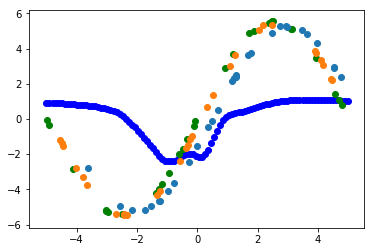

/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


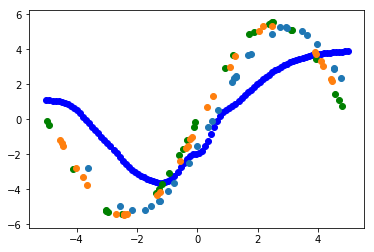

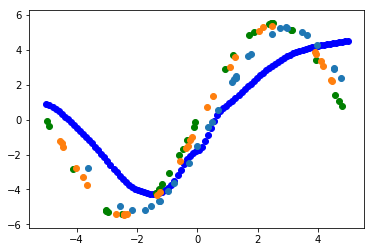

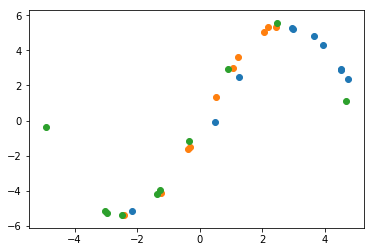

In [11]:
Tasks = next(task_loader3)
plot_pred_after(Tasks, M)
show_tasks(Tasks)